# Forex Dataset Labeling 

- LeftDist
- MidDist 
- RightDist 

## Algorithms

- Gaussian Naive Bayes
- Multinomial Naive Bayes
- Bernoulli Naive Bayes

In [1]:
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp 

from sklearn.preprocessing import scale, MinMaxScaler, Normalizer, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import roc_auc_score,roc_curve, classification_report, recall_score, f1_score
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

import timeit
from warnings import filterwarnings
filterwarnings('ignore')

/home/asus/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
def describe(data):
    desc_df = data.describe().T
    null_count = data.isnull().sum()
    null_percent = (data.isnull().sum() / data.count())*100
    variance = data.var()

    desc_df["variance"] =  round(variance,3)
    desc_df["null_values"] = round(null_count,3)
    desc_df["null__rate"] = round(null_percent,3)
    return desc_df.T

def numeric_categoric_variable(data):
    name_of_col = list(data.columns)
    num_var_list = []
    str_var_list = []
    drop_col=[]

    str_var_list = name_of_col.copy()
    for var in name_of_col:
        # check if column belongs to numeric type
        if (data[var].dtypes not in (np.object, np.str)):
            str_var_list.remove(var)
            num_var_list.append(var)
        # drop the omit column from list
    for var in drop_col:
        if var in str_var_list:
            str_var_list.remove(var)
        if var in num_var_list:
            num_var_list.remove(var)
    print("Numeric Column  :\n", num_var_list,
          "\n\nCategoric Column :\n", str_var_list)
    return num_var_list, str_var_list

def sortDifferentCategory(data):
    def takeSecond(elem):
        return elem[1]

    listem = []
    for i in data.select_dtypes(include=["object", "int64", "float64"]).columns:
        listem.append([i, data[i].value_counts().count()])

    return sorted(listem, key=takeSecond ,reverse=False)

def nulldata_check(data, ascending=False):
    count = data.isnull().sum().sort_values(ascending=ascending).to_frame()
    percent = (data.isnull().sum().sort_values(ascending=ascending)/data.iloc[:,-1].count()).to_frame().round(decimals=4)
    df = pd.concat([count, percent], axis=1)
    df.columns = ["count","percentage"]
    return df

def dummy_df(df, todummy_list):
    for x in todummy_list:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
        df = df.drop(x, 1)
        df = pd.concat([df, dummies], axis=1)
    return df

def layer1(data, remove_col, threshold):
    corr_col=set()
    data2 = data.drop(remove_col, axis=1)
    corrmat=data2.corr()
    for i in range(len(corrmat.columns)):
        for j in range(i):
            if abs(corrmat.iloc[i,j] > threshold):
                colname=corrmat.columns[i]
                corr_col.add(colname)
    corr_col=list(corr_col)
    layer1_df = data.drop(corr_col, axis=1)
    #layer1_df["labels"] = data_norm["labels"]
    return layer1_df

def layer2(new_df, target, num_feats):
    x = new_df.drop(target, axis=1)
    y = new_df[target]
    cor_list = []
    feature_name = list(x.columns)
    for i in list(x.columns):
        cor = np.corrcoef(x[i],y)[0,1]
        cor_list.append(cor)

    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    cor_feature = x.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    return cor_feature

def featureselection_pca(data_minmax, target, threshold):
    x = data_minmax.drop([target], axis=1)
    y = data_minmax[target]
    pca = PCA()    
    X_pca = pca.fit_transform(x)
    arr = np.cumsum(np.round(pca.explained_variance_ratio_, decimals = 4)*100)
    num_var = sum((arr < threshold*100)) + 1 
    print('pca sonrası değişken sayısı: ',num_var)
    X_pcad = pd.DataFrame(X_pca[:,0:num_var], index = x.index)
    X_pcad[target] = y
    return X_pcad

def featureselection_randomforest(xtrain,ytrain, target, params, top_feat, cv=10, n_jobs=-1, verbose=2):
    model = RandomForestRegressor()
    gridsearch_cv = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose)
    grid_cv_model = gridsearch_cv.fit(xtrain, ytrain)
    # best parameters
    model.max_depth = grid_cv_model.best_params_["max_depth"]
    model.max_features = grid_cv_model.best_params_["max_features"] 
    model.n_estimators = grid_cv_model.best_params_["n_estimators"]
    model.min_samples_split= grid_cv_model.best_params_["min_samples_split"]
    # tuned model
    model_tuned = model.fit(xtrain, ytrain)
    #y_pred = model_tuned.predict(xtest)
    
    importance = pd.DataFrame({"importance": model.feature_importances_*100}, index = xtrain.columns)
    rf_columns = importance.sort_values(by="importance", axis=0, ascending=False).head(top_feat).index
    new_df = xtrain[rf_columns]
    new_df[target] = ytrain
    return new_df

In [3]:
def normalization_minmax(dataframe, target):
    x = dataframe.drop(target, axis=1)
    y = dataframe[target]
    scaler = preprocessing.MinMaxScaler()
    scaler.fit(x)
    array = scaler.transform(x)
    data_minmax = pd.DataFrame(array, columns=x.columns)
    data_minmax[target] = y
    data_minmax.head()
    return data_minmax

def train_test_splitting(data, target, test_size=0.25, random_state=0, shuffle=False):
    x = data.drop([target], axis=1)
    y = data[target]
    xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=test_size, random_state=random_state, shuffle=shuffle)
    print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)
    return xtrain, xtest, ytrain, ytest

def evaluation_metrics(ytest, y_pred):
    print("accuracy : ", round(accuracy_score(ytest,y_pred),5),
      "\nprecision: ", round(precision_score(ytest,y_pred, average="micro"),5),
      "\nrecall   : ", round(recall_score(ytest,y_pred, average="micro"),5),
      "\nf1-score : ", round(f1_score(ytest,y_pred, average="micro"),5))
    
def histogram(datas, bins=40, xlabelsize=6, ylabelsize=6, figsize=(10,5)):
    datas.hist(figsize=figsize, bins=bins, xlabelsize=xlabelsize, ylabelsize=ylabelsize)
    plt.show()

def heatmap(data, figsize=(16,8)):
    fig, ax = plt.subplots(figsize=figsize) 
    sns.heatmap(data.corr(), annot=True, linewidths=.3, ax=ax)
    plt.show()

In [4]:
def GaussianNaiveBayes(xtrain, ytrain, xtest):
    gnb = GaussianNB()
    gnb_model = gnb.fit(xtrain, ytrain)
    y_pred = gnb_model.predict(xtest)
    return y_pred, gnb_model

def MultinomialNaiveBayes(xtrain, ytrain, xtest):
    gnb = MultinomialNB()
    gnb_model = gnb.fit(xtrain, ytrain)
    y_pred = gnb_model.predict(xtest)
    return y_pred, gnb_model

def BernoulliNaiveBayes(xtrain, ytrain, xtest):
    gnb = BernoulliNB()
    gnb_model = gnb.fit(xtrain, ytrain)
    y_pred = gnb_model.predict(xtest)
    return y_pred, gnb_model

def GaussianNBTuning(xtrain,ytrain, xtest, ytest, params, cv=10, n_jobs=-1, verbose=2):
    model = GaussianNB()
    gridsearch_cv = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose)
    grid_cv_model = gridsearch_cv.fit(xtrain, ytrain)
    # best parameters
    model.priors = grid_cv_model.best_params_["priors"]
    # tuned model
    model_tuned = model.fit(xtrain, ytrain)
    y_pred = model_tuned.predict(xtest)
    return ytest, y_pred, model, grid_cv_model.best_params_

def MultinomialNBTuning(xtrain,ytrain, xtest, ytest, params, cv=10, n_jobs=-1, verbose=2):
    model = MultinomialNB()
    gridsearch_cv = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose)
    grid_cv_model = gridsearch_cv.fit(xtrain, ytrain)
    # best parameters
    model.alpha = grid_cv_model.best_params_["alpha"]
    # tuned model
    model_tuned = model.fit(xtrain, ytrain)
    y_pred = model_tuned.predict(xtest)
    return ytest, y_pred, model, grid_cv_model.best_params_

def BernoulliNBTuning(xtrain,ytrain, xtest, ytest, params, cv=10, n_jobs=-1, verbose=2):
    model = BernoulliNB()
    gridsearch_cv = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose)
    grid_cv_model = gridsearch_cv.fit(xtrain, ytrain)
    # best parameters
    model.alpha = grid_cv_model.best_params_["alpha"]
    # tuned model
    model_tuned = model.fit(xtrain, ytrain)
    y_pred = model_tuned.predict(xtest)
    return ytest, y_pred, model, grid_cv_model.best_params_

### **Data Importing**

In [5]:
data = pd.read_excel("HW_Data_Set.xlsx")
data.head()

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_416,ind_418,ind_420,ind_422,ind_424,ind_426,ind_428,20_target,50_target,90_target
0,19,17,100.0,85.714286,14.285714,72.363515,60.808814,23.80,17.62,11.73,...,-49.6,-54,-152,-353,1.0,0.498547,0.701906,15.135802,35.625252,36.997753
1,24,19,100.0,78.571429,21.428571,74.275883,64.366798,11.45,18.16,12.22,...,-55.6,-60,-158,-359,1.0,0.537088,0.690833,15.143348,35.643013,37.016198
2,30,24,100.0,71.428571,28.571429,75.140402,65.915803,8.75,17.86,12.28,...,-58.4,-60,-160,-362,1.0,0.615169,0.693040,15.146870,35.651301,-37.024805
3,37,30,100.0,64.285714,35.714286,76.677846,68.584234,7.80,14.76,12.61,...,-61.8,-65,-166,-367,1.0,0.661517,0.673418,15.153283,0.000000,-37.040483
4,41,37,100.0,57.142857,42.857143,81.603007,76.455495,14.90,11.92,14.25,...,-79.8,-86,-186,-388,1.0,0.747204,0.700522,-15.179065,-35.727079,-37.103503


# **1. Data Exploration**

### **1.1. Describe Dataset**

In [6]:
data.shape

(6167, 136)

In [7]:
describe(data)

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_412,ind_414,ind_416,ind_418,ind_424,ind_426,ind_428,20_target,50_target,90_target
count,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,...,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000
mean,-0.803146,-0.803470,48.388890,48.289282,0.099609,49.488867,-18.497518,11.771485,11.773550,11.773392,...,0.000224,28.529204,-8.554792,-28.166694,0.490297,0.498188,0.490174,-0.057102,-2.906358,-3.315072
std,23.624403,23.624144,36.388526,36.478009,60.414625,12.198722,68.281120,6.803997,5.786089,4.970499,...,0.005660,26.316896,16.100087,23.271524,0.425376,0.228547,0.150483,14.834497,34.559778,36.841541
min,-131.000000,-131.000000,0.000000,0.000000,-100.000000,12.134540,-625.093855,1.050000,1.660000,2.580000,...,-0.023790,0.000000,-103.800000,-188.000000,0.000000,0.000000,0.083530,-15.780588,-37.142889,-38.573858
25%,-14.000000,-14.000000,14.285714,14.285714,-50.000000,40.868503,-45.687212,6.850000,7.260000,7.635000,...,-0.003230,10.700000,-11.700000,-39.000000,0.000000,0.323783,0.379894,-15.350354,-36.208094,-37.695273
50%,0.000000,0.000000,50.000000,50.000000,0.000000,49.549766,-2.817298,10.550000,11.040000,11.270000,...,-0.000053,21.300000,0.000000,-22.000000,0.473684,0.495192,0.487078,0.000000,-34.267756,-35.788391
75%,13.000000,13.000000,85.714286,85.714286,57.142857,58.504375,28.072613,14.950000,15.040000,14.960000,...,0.003414,38.400000,0.000000,-11.000000,1.000000,0.675730,0.601508,15.385945,35.879524,37.521892
max,76.000000,76.000000,100.000000,100.000000,100.000000,84.821848,81.105847,82.900000,54.240000,37.050000,...,0.023340,281.800000,0.000000,0.000000,1.000000,1.000000,0.868534,15.768767,37.038694,38.465649
variance,558.112000,558.100000,1324.125000,1330.645000,3649.927000,148.809000,4662.311000,46.294000,33.479000,24.706000,...,0.000000,692.579000,259.213000,541.564000,0.181000,0.052000,0.023000,220.062000,1194.378000,1357.299000
null_values,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### **1.2. Categoric and Numeric variables Analysis**

In [8]:
num, cat = numeric_categoric_variable(data)

Numeric Column  :
 ['ind_5', 'ind_6', 'ind_8', 'ind_9', 'ind_10', 'ind_12', 'ind_13', 'ind_14', 'ind_15', 'ind_16', 'ind_17', 'ind_18', 'ind_19', 'ind_20', 'ind_21', 'ind_22', 'ind_23', 'ind_25', 'ind_26', 'ind_27', 'ind_28', 'ind_29', 'ind_30', 'ind_31', 'ind_32', 'ind_33', 'ind_34', 'ind_35', 'ind_36', 'ind_37', 'ind_39', 'ind_40', 'ind_41', 'ind_42', 'ind_43', 'ind_44', 'ind_45', 'ind_46', 'ind_47', 'ind_48', 'ind_49', 'ind_50', 'ind_51', 'ind_52', 'ind_53', 'ind_56', 'ind_58', 'ind_61', 'ind_62', 'ind_65', 'ind_67', 'ind_70', 'ind_71', 'ind_74', 'ind_77', 'ind_82', 'ind_83', 'ind_88', 'ind_92', 'ind_102', 'ind_116', 'ind_118', 'ind_122', 'ind_124', 'ind_128', 'ind_130', 'ind_132', 'ind_134', 'ind_136', 'ind_139', 'ind_142', 'ind_145', 'ind_147', 'ind_150', 'ind_153', 'ind_156', 'ind_164', 'ind_168', 'ind_172', 'ind_176', 'ind_179', 'ind_181', 'ind_188', 'ind_194', 'ind_212', 'ind_217', 'ind_225', 'ind_228', 'ind_234', 'ind_237', 'ind_239', 'ind_241', 'ind_243', 'ind_309', 'ind_310'

In [9]:
sortDifferentCategory(data)

[['ind_109', 2],
 ['ind_40', 6],
 ['ind_82', 6],
 ['ind_217', 6],
 ['ind_28', 7],
 ['ind_349', 7],
 ['ind_8', 15],
 ['ind_9', 15],
 ['ind_351', 17],
 ['ind_352', 17],
 ['ind_70', 18],
 ['ind_67', 22],
 ['ind_344', 22],
 ['ind_83', 25],
 ['ind_10', 29],
 ['ind_77', 37],
 ['ind_61', 38],
 ['ind_74', 42],
 ['ind_71', 46],
 ['ind_58', 50],
 ['ind_122', 52],
 ['ind_65', 55],
 ['ind_62', 64],
 ['ind_347', 69],
 ['ind_42', 71],
 ['ind_334', 71],
 ['ind_19', 83],
 ['ind_21', 84],
 ['ind_52', 90],
 ['ind_136', 91],
 ['ind_134', 93],
 ['ind_43', 94],
 ['ind_56', 102],
 ['ind_407', 103],
 ['ind_345', 108],
 ['ind_44', 109],
 ['ind_45', 126],
 ['ind_124', 128],
 ['ind_53', 131],
 ['ind_116', 131],
 ['ind_46', 135],
 ['ind_418', 139],
 ['ind_20', 141],
 ['ind_410', 143],
 ['ind_234', 157],
 ['ind_47', 159],
 ['ind_5', 162],
 ['ind_6', 162],
 ['ind_48', 175],
 ['ind_23', 177],
 ['ind_49', 189],
 ['ind_22', 192],
 ['ind_406', 200],
 ['ind_128', 201],
 ['ind_324', 241],
 ['ind_309', 249],
 ['ind_50', 

In [10]:
data.groupby("ind_40").count()

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_416,ind_418,ind_420,ind_422,ind_424,ind_426,ind_428,20_target,50_target,90_target
ind_40,,,,,,,,,,,,,,,,,,,,,
1,51,51,51,51,51,51,51,51,51,51,...,51,51,51,51,51,51,51,51,51,51
2,325,325,325,325,325,325,325,325,325,325,...,325,325,325,325,325,325,325,325,325,325
3,2799,2799,2799,2799,2799,2799,2799,2799,2799,2799,...,2799,2799,2799,2799,2799,2799,2799,2799,2799,2799
4,2594,2594,2594,2594,2594,2594,2594,2594,2594,2594,...,2594,2594,2594,2594,2594,2594,2594,2594,2594,2594
5,319,319,319,319,319,319,319,319,319,319,...,319,319,319,319,319,319,319,319,319,319
6,79,79,79,79,79,79,79,79,79,79,...,79,79,79,79,79,79,79,79,79,79


In [11]:
data.groupby("ind_420").count().tail(5)

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_414,ind_416,ind_418,ind_422,ind_424,ind_426,ind_428,20_target,50_target,90_target
ind_420,,,,,,,,,,,,,,,,,,,,,
288,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
290,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
291,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
297,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
?,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,...,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041


### **1.3. NULL Value Checking**

In [12]:
nulldata_check(data).sort_values(by="count",ascending=False).head(7)

,count,percentage
90_target,0,0.0
ind_416,0,0.0
ind_404,0,0.0
ind_406,0,0.0
ind_407,0,0.0
ind_410,0,0.0
ind_412,0,0.0


# **Data Preprocessing**

### **2.1. Noise data cleaning**

In [13]:
#data["ind_420"] = data["ind_420"].replace("?", np.nan)
#data["ind_422"] = data["ind_422"].replace("?", np.nan)
data = data.drop(["ind_420", "ind_422"],axis=1)

### **2.2. Dummy Transformation**

In [14]:
data_dummy = dummy_df(data, ["ind_109"])
data_dummy2 = dummy_df(data, ["ind_109","ind_40"])

num, cat = numeric_categoric_variable(data_dummy)
data_dummy.head()

Numeric Column  :
 ['ind_5', 'ind_6', 'ind_8', 'ind_9', 'ind_10', 'ind_12', 'ind_13', 'ind_14', 'ind_15', 'ind_16', 'ind_17', 'ind_18', 'ind_19', 'ind_20', 'ind_21', 'ind_22', 'ind_23', 'ind_25', 'ind_26', 'ind_27', 'ind_28', 'ind_29', 'ind_30', 'ind_31', 'ind_32', 'ind_33', 'ind_34', 'ind_35', 'ind_36', 'ind_37', 'ind_39', 'ind_40', 'ind_41', 'ind_42', 'ind_43', 'ind_44', 'ind_45', 'ind_46', 'ind_47', 'ind_48', 'ind_49', 'ind_50', 'ind_51', 'ind_52', 'ind_53', 'ind_56', 'ind_58', 'ind_61', 'ind_62', 'ind_65', 'ind_67', 'ind_70', 'ind_71', 'ind_74', 'ind_77', 'ind_82', 'ind_83', 'ind_88', 'ind_92', 'ind_102', 'ind_116', 'ind_118', 'ind_122', 'ind_124', 'ind_128', 'ind_130', 'ind_132', 'ind_134', 'ind_136', 'ind_139', 'ind_142', 'ind_145', 'ind_147', 'ind_150', 'ind_153', 'ind_156', 'ind_164', 'ind_168', 'ind_172', 'ind_176', 'ind_179', 'ind_181', 'ind_188', 'ind_194', 'ind_212', 'ind_217', 'ind_225', 'ind_228', 'ind_234', 'ind_237', 'ind_239', 'ind_241', 'ind_243', 'ind_309', 'ind_310'

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_416,ind_418,ind_424,ind_426,ind_428,20_target,50_target,90_target,ind_109_GREEN,ind_109_RED
0,19,17,100.0,85.714286,14.285714,72.363515,60.808814,23.80,17.62,11.73,...,-49.6,-54,1.0,0.498547,0.701906,15.135802,35.625252,36.997753,1,0
1,24,19,100.0,78.571429,21.428571,74.275883,64.366798,11.45,18.16,12.22,...,-55.6,-60,1.0,0.537088,0.690833,15.143348,35.643013,37.016198,1,0
2,30,24,100.0,71.428571,28.571429,75.140402,65.915803,8.75,17.86,12.28,...,-58.4,-60,1.0,0.615169,0.693040,15.146870,35.651301,-37.024805,1,0
3,37,30,100.0,64.285714,35.714286,76.677846,68.584234,7.80,14.76,12.61,...,-61.8,-65,1.0,0.661517,0.673418,15.153283,0.000000,-37.040483,1,0
4,41,37,100.0,57.142857,42.857143,81.603007,76.455495,14.90,11.92,14.25,...,-79.8,-86,1.0,0.747204,0.700522,-15.179065,-35.727079,-37.103503,1,0


### **2.3. Numeric Target to Categoric Transformation**

Burda inceledigimizde **20_target** degiskeni 3 farkli dagilim gostermektedir. 


1.   (-10 ve -20) arasinda sola dogru carpiklik oldugu icin -10-20 arasinda **LeftSkew** diye bir kategori olusturuyoruz.
2.   (-5 ve +5) arasinda ortada dagilim gosteren degerlere **Neutral** diye bir kategori olusturuyoruz.
3.   (+10 ve +20) arasinda degerlere **RightSkew** diye bir kategori olusturuyoruz.



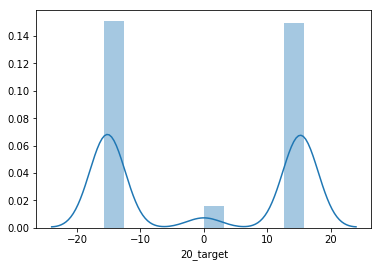

In [15]:
sns.distplot(data_dummy["20_target"])
plt.show()

Burda inceledigimizde **50_target** degiskeni 3 farkli dagilim gostermektedir. 


1.   (-20 ve -40) arasinda sola dogru carpiklik oldugu icin -10-20 arasinda **LeftSkew** diye bir kategori olusturuyoruz.
2.   (-5 ve +5) arasinda ortada dagilim gosteren degerlere **Neutral** diye bir kategori olusturuyoruz.
3.   (+20 ve +40) arasinda degerlere **RightSkew** diye bir kategori olusturuyoruz.



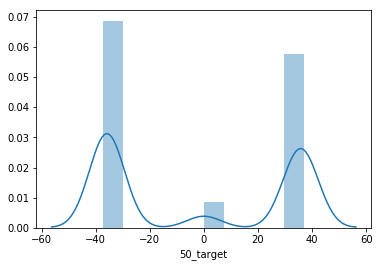

In [16]:
sns.distplot(data_dummy["50_target"])
plt.show()

Burda inceledigimizde **90_target** degiskeni 3 farkli dagilim gostermektedir. 


1.   (-20 ve -40) arasinda sola dogru carpiklik oldugu icin -10-20 arasinda **LeftSkew** diye bir kategori olusturuyoruz.
2.   (-5 ve +5) arasinda ortada dagilim gosteren degerlere **Neutral** diye bir kategori olusturuyoruz.
3.   (+20 ve +40) arasinda degerlere **RightSkew** diye bir kategori olusturuyoruz.



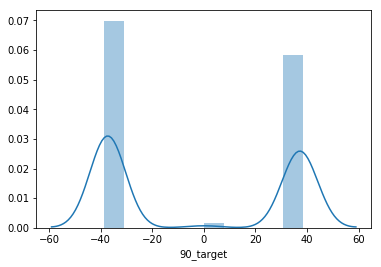

In [17]:
sns.distplot(data_dummy["90_target"])
plt.show()

In [18]:
leftDist = data_dummy.loc[:,:][(data_dummy["90_target"]>-40) & (data_dummy["90_target"]< -15)]
leftDist["90_target"] = 1 #"leftDist"

midDist = data_dummy.loc[:,:][(data_dummy["90_target"]> -5) & (data_dummy["90_target"]< 5)]
midDist["90_target"] = 2 #"midDist"

rightDist = data_dummy.loc[:,:][(data_dummy["90_target"]> 15) & (data_dummy["90_target"]< 40)]
rightDist["90_target"] = 3 #"rightDist"

data_categoric = pd.concat([leftDist, midDist, rightDist])
data_categoric = data_categoric.drop(["20_target", "50_target"], axis=1)
data_categoric.groupby("90_target").count()

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_410,ind_412,ind_414,ind_416,ind_418,ind_424,ind_426,ind_428,ind_109_GREEN,ind_109_RED
90_target,,,,,,,,,,,,,,,,,,,,,
1,3318,3318,3318,3318,3318,3318,3318,3318,3318,3318,...,3318,3318,3318,3318,3318,3318,3318,3318,3318,3318
2,76,76,76,76,76,76,76,76,76,76,...,76,76,76,76,76,76,76,76,76,76
3,2773,2773,2773,2773,2773,2773,2773,2773,2773,2773,...,2773,2773,2773,2773,2773,2773,2773,2773,2773,2773


In [19]:
data_categoric.head()

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_412,ind_414,ind_416,ind_418,ind_424,ind_426,ind_428,90_target,ind_109_GREEN,ind_109_RED
2,30,24,100.0,71.428571,28.571429,75.140402,65.915803,8.75,17.86,12.28,...,0.003561,2.7,-58.4,-60,1.0,0.615169,0.693040,1,1,0
3,37,30,100.0,64.285714,35.714286,76.677846,68.584234,7.80,14.76,12.61,...,0.004366,0.9,-61.8,-65,1.0,0.661517,0.673418,1,1,0
4,41,37,100.0,57.142857,42.857143,81.603007,76.455495,14.90,11.92,14.25,...,0.004198,0.1,-79.8,-86,1.0,0.747204,0.700522,1,1,0
5,45,41,100.0,50.000000,50.000000,80.092497,74.144360,18.75,12.74,15.18,...,0.005395,8.8,-78.1,-84,1.0,0.794403,0.730549,1,1,0
6,49,45,100.0,42.857143,57.142857,79.625649,73.412327,15.45,13.52,15.84,...,0.005749,12.8,-71.7,-84,1.0,0.854144,0.746727,1,1,0


In [20]:
data_categoric.groupby("90_target").count()

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_410,ind_412,ind_414,ind_416,ind_418,ind_424,ind_426,ind_428,ind_109_GREEN,ind_109_RED
90_target,,,,,,,,,,,,,,,,,,,,,
1,3318,3318,3318,3318,3318,3318,3318,3318,3318,3318,...,3318,3318,3318,3318,3318,3318,3318,3318,3318,3318
2,76,76,76,76,76,76,76,76,76,76,...,76,76,76,76,76,76,76,76,76,76
3,2773,2773,2773,2773,2773,2773,2773,2773,2773,2773,...,2773,2773,2773,2773,2773,2773,2773,2773,2773,2773


### **2.4. Normalization (Min-Max)**

In [21]:
data_minmax = normalization_minmax(data_categoric, "90_target")
data_minmax.head()

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_412,ind_414,ind_416,ind_418,ind_424,ind_426,ind_428,ind_109_GREEN,ind_109_RED,90_target
0,0.777778,0.748792,1.0,0.714286,0.642857,0.866807,0.978490,0.094075,0.308102,0.281404,...,0.580332,0.009581,0.437380,0.680851,1.0,0.615169,0.776441,1.0,0.0,3
1,0.811594,0.777778,1.0,0.642857,0.678571,0.887958,0.982269,0.082468,0.249144,0.290978,...,0.597408,0.003194,0.404624,0.654255,1.0,0.661517,0.751445,1.0,0.0,3
2,0.830918,0.811594,1.0,0.571429,0.714286,0.955717,0.993415,0.169212,0.195131,0.338555,...,0.593840,0.000355,0.231214,0.542553,1.0,0.747204,0.785973,1.0,0.0,1
3,0.850242,0.830918,1.0,0.500000,0.750000,0.934936,0.990142,0.216249,0.210727,0.365535,...,0.619234,0.031228,0.247592,0.553191,1.0,0.794403,0.824224,1.0,0.0,1
4,0.869565,0.850242,1.0,0.428571,0.785714,0.928513,0.989106,0.175932,0.225561,0.384682,...,0.626743,0.045422,0.309249,0.553191,1.0,0.854144,0.844833,1.0,0.0,1


### **2.5. Without Normalization**

In [22]:
data_without_norm = data_categoric
data_without_norm.head()

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_412,ind_414,ind_416,ind_418,ind_424,ind_426,ind_428,90_target,ind_109_GREEN,ind_109_RED
2,30,24,100.0,71.428571,28.571429,75.140402,65.915803,8.75,17.86,12.28,...,0.003561,2.7,-58.4,-60,1.0,0.615169,0.693040,1,1,0
3,37,30,100.0,64.285714,35.714286,76.677846,68.584234,7.80,14.76,12.61,...,0.004366,0.9,-61.8,-65,1.0,0.661517,0.673418,1,1,0
4,41,37,100.0,57.142857,42.857143,81.603007,76.455495,14.90,11.92,14.25,...,0.004198,0.1,-79.8,-86,1.0,0.747204,0.700522,1,1,0
5,45,41,100.0,50.000000,50.000000,80.092497,74.144360,18.75,12.74,15.18,...,0.005395,8.8,-78.1,-84,1.0,0.794403,0.730549,1,1,0
6,49,45,100.0,42.857143,57.142857,79.625649,73.412327,15.45,13.52,15.84,...,0.005749,12.8,-71.7,-84,1.0,0.854144,0.746727,1,1,0


# **3. Feature Selection**

### **3.1. Principal Component Analysis**

In [23]:
data_pca = featureselection_pca(data_minmax, "90_target", 0.9)
data_pca.head()

pca sonrası değişken sayısı:  19


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,90_target
0,-2.088737,0.072149,-0.135119,0.317724,-0.062843,0.280218,0.375154,-0.605005,0.232259,0.319001,-0.261715,0.788576,0.268427,-0.474156,-0.203423,0.089478,-0.246062,0.361119,-0.002372,3
1,-2.203106,0.090405,-0.066407,0.261085,-0.005468,0.251994,0.388037,-0.587139,0.199041,0.326763,-0.170757,0.828007,0.252351,-0.480077,-0.183597,0.063912,-0.240448,0.327890,0.011579,3
2,-2.528751,0.126773,0.046819,0.234280,0.029756,0.354077,0.427985,-0.621044,0.236388,0.310995,-0.077167,0.849048,0.119429,-0.508945,-0.242452,0.143253,-0.363971,0.486983,-0.044026,1
3,-2.441075,-0.021457,0.129813,0.226355,-0.041915,0.255516,0.444542,-0.604685,0.225015,0.263539,-0.119784,0.695764,0.219255,-0.533952,-0.268072,0.160373,-0.411566,0.459309,-0.035494,1
4,-2.406857,-0.110602,0.194157,0.207484,-0.064106,0.194622,0.454288,-0.586721,0.208578,0.228609,-0.126674,0.614212,0.276129,-0.541849,-0.236443,0.163296,-0.432941,0.430018,-0.027181,1


### **3.2. Correlation based Feature Selection**

In [24]:
data_corr = layer1(data_minmax, "90_target", 0.6)
data_corr.head()

,ind_5,ind_8,ind_9,ind_14,ind_18,ind_26,ind_27,ind_28,ind_40,ind_42,...,ind_332,ind_334,ind_338,ind_340,ind_344,ind_347,ind_349,ind_351,ind_416,90_target
0,0.777778,1.0,0.714286,0.094075,0.188641,0.718925,0.373539,1.0,0.4,0.427083,...,0.207037,0.851232,0.960232,0.748993,1.0,0.0,1.0,0.0,0.437380,3
1,0.811594,1.0,0.642857,0.082468,0.193317,0.684934,0.348484,1.0,0.4,0.416667,...,0.205407,0.851232,0.960305,0.749100,1.0,0.0,1.0,0.0,0.404624,3
2,0.830918,1.0,0.571429,0.169212,0.215100,0.632729,0.378814,1.0,0.2,0.281250,...,0.203802,0.851232,0.960377,0.749526,1.0,0.0,1.0,0.0,0.231214,1
3,0.850242,1.0,0.500000,0.216249,0.229927,0.589894,0.360541,1.0,0.2,0.427083,...,0.202222,0.851232,0.960450,0.749490,1.0,0.0,1.0,0.0,0.247592,1
4,0.869565,1.0,0.428571,0.175932,0.241218,0.553741,0.333884,1.0,0.2,0.489583,...,0.200667,0.851232,0.960523,0.749480,1.0,0.0,1.0,0.0,0.309249,1


# **4. Visualization**

### **4.1. Histogram (Distribution)**

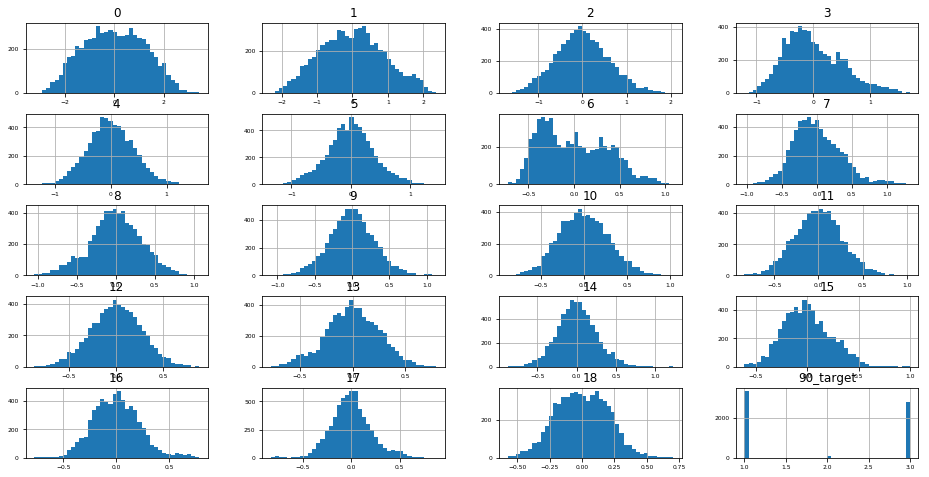

In [25]:
histogram(data_pca, figsize=(16,8))

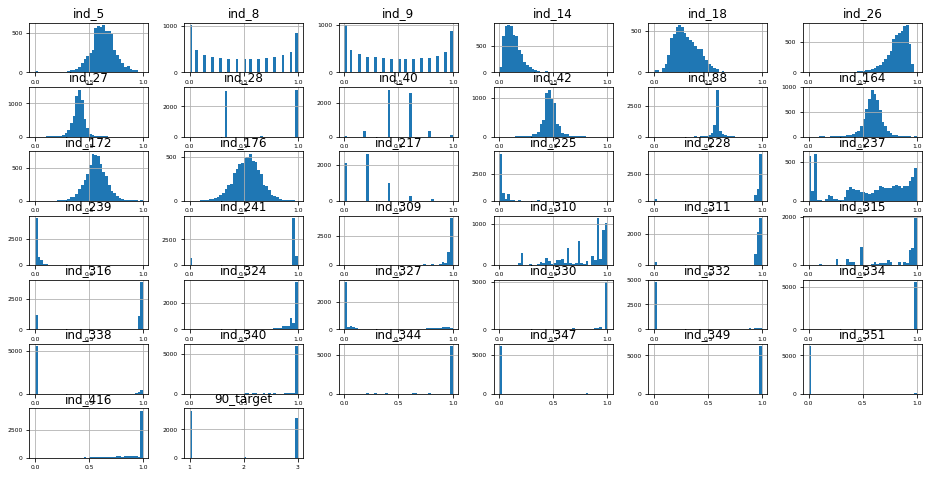

In [31]:
histogram(data_corr, figsize=(16,8))

### **4.2. Correlation HeatMap**

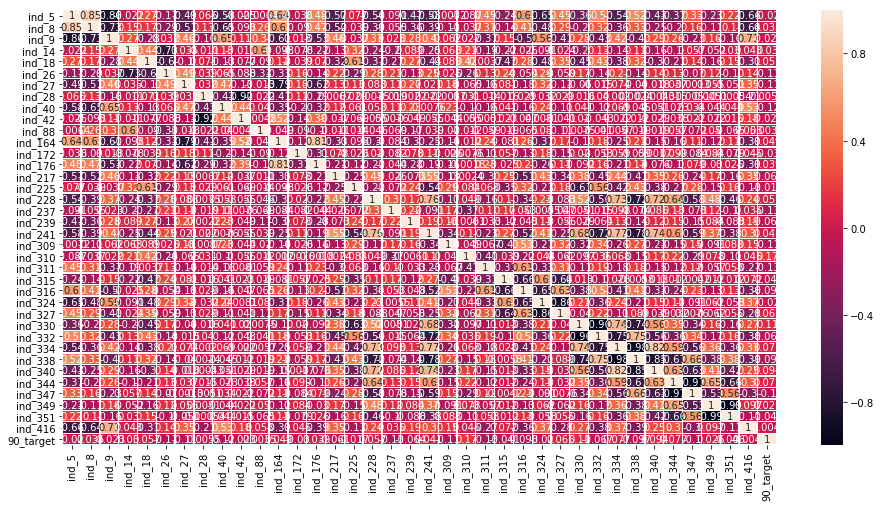

In [32]:
heatmap(data_corr.corr())

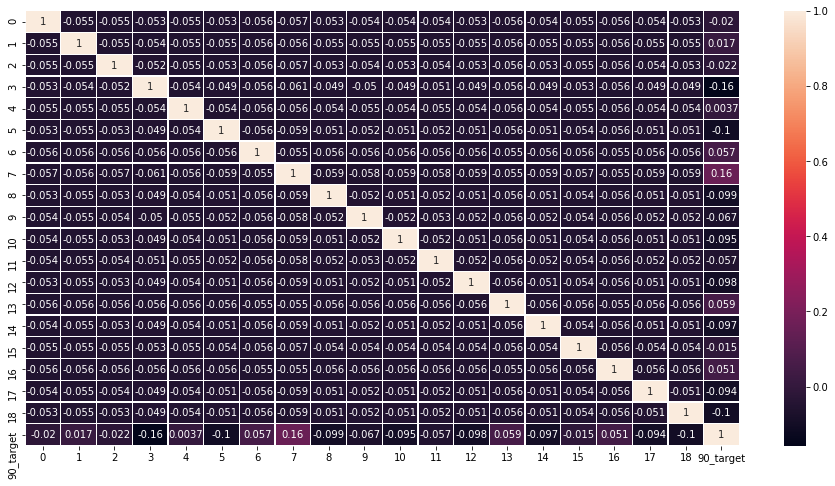

In [33]:
heatmap(data_pca.corr())

# **Modelling**
- Gaussian Naive Bayes
- Multinomial Naive Bayes 
- Bernoulli Naive Bayes

## 4.1. Gaussian Naive Bayes

### 4.1.1. PCA based FS

In [27]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_pca, "90_target")
y_pred, gnb_model = GaussianNaiveBayes(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("Confusion Matrix: \n",confusion_matrix(ytest, y_pred))
print("\n",classification_report(ytest, y_pred))

(4625, 19) (1542, 19) (4625,) (1542,)
accuracy :  0.52853 
precision:  0.52853 
recall   :  0.52853 
f1-score :  0.52853
Confusion Matrix: 
 [[507 334]
 [393 308]]

               precision    recall  f1-score   support

           1       0.56      0.60      0.58       841
           3       0.48      0.44      0.46       701

   micro avg       0.53      0.53      0.53      1542
   macro avg       0.52      0.52      0.52      1542
weighted avg       0.53      0.53      0.53      1542



### 4.1.2. Correlation based FS

In [28]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_corr, "90_target")
y_pred, gnb_model = GaussianNaiveBayes(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("Confusion Matrix: \n",confusion_matrix(ytest, y_pred))
print("\n",classification_report(ytest, y_pred, ))

(4625, 37) (1542, 37) (4625,) (1542,)
accuracy :  0.43256 
precision:  0.43256 
recall   :  0.43256 
f1-score :  0.43256
Confusion Matrix: 
 [[ 73  17 751]
 [  0   0   0]
 [ 88  19 594]]

               precision    recall  f1-score   support

           1       0.45      0.09      0.15       841
           2       0.00      0.00      0.00         0
           3       0.44      0.85      0.58       701

   micro avg       0.43      0.43      0.43      1542
   macro avg       0.30      0.31      0.24      1542
weighted avg       0.45      0.43      0.34      1542



In [29]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_minmax, "90_target")
y_pred, bnb_model = GaussianNaiveBayes(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("Confusion Matrix: \n",confusion_matrix(ytest, y_pred))
print("\n",classification_report(ytest, y_pred, ))

(4625, 132) (1542, 132) (4625,) (1542,)
accuracy :  0.38975 
precision:  0.38975 
recall   :  0.38975 
f1-score :  0.38975
Confusion Matrix: 
 [[140  55 646]
 [  0   0   0]
 [188  52 461]]

               precision    recall  f1-score   support

           1       0.43      0.17      0.24       841
           2       0.00      0.00      0.00         0
           3       0.42      0.66      0.51       701

   micro avg       0.39      0.39      0.39      1542
   macro avg       0.28      0.27      0.25      1542
weighted avg       0.42      0.39      0.36      1542



## 4.2. Multinomial Naive Bayes

In [30]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_corr, "90_target")
y_pred, gnb_model = MultinomialNaiveBayes(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("Confusion Matrix: \n",confusion_matrix(ytest, y_pred))
print("\n",classification_report(ytest, y_pred, ))

(4625, 37) (1542, 37) (4625,) (1542,)
accuracy :  0.53956 
precision:  0.53956 
recall   :  0.53956 
f1-score :  0.53956
Confusion Matrix: 
 [[756  85]
 [625  76]]

               precision    recall  f1-score   support

           1       0.55      0.90      0.68       841
           3       0.47      0.11      0.18       701

   micro avg       0.54      0.54      0.54      1542
   macro avg       0.51      0.50      0.43      1542
weighted avg       0.51      0.54      0.45      1542



In [31]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_minmax, "90_target")
y_pred, bnb_model = MultinomialNaiveBayes(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("Confusion Matrix: \n",confusion_matrix(ytest, y_pred))
print("\n",classification_report(ytest, y_pred, ))

(4625, 132) (1542, 132) (4625,) (1542,)
accuracy :  0.52529 
precision:  0.52529 
recall   :  0.52529 
f1-score :  0.52529
Confusion Matrix: 
 [[534 307]
 [425 276]]

               precision    recall  f1-score   support

           1       0.56      0.63      0.59       841
           3       0.47      0.39      0.43       701

   micro avg       0.53      0.53      0.53      1542
   macro avg       0.52      0.51      0.51      1542
weighted avg       0.52      0.53      0.52      1542



## 4.3. Bernoulli Naive Bayes

### 4.3.1. PCA based FS

In [32]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_pca, "90_target")
y_pred, bnb_model = BernoulliNaiveBayes(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("Confusion Matrix: \n",confusion_matrix(ytest, y_pred))
print("\n",classification_report(ytest, y_pred, ))

(4625, 19) (1542, 19) (4625,) (1542,)
accuracy :  0.53567 
precision:  0.53567 
recall   :  0.53567 
f1-score :  0.53567
Confusion Matrix: 
 [[528 313]
 [403 298]]

               precision    recall  f1-score   support

           1       0.57      0.63      0.60       841
           3       0.49      0.43      0.45       701

   micro avg       0.54      0.54      0.54      1542
   macro avg       0.53      0.53      0.53      1542
weighted avg       0.53      0.54      0.53      1542



### 4.3.2. Correlation based FS

In [33]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_corr, "90_target")
y_pred, bnb_model = BernoulliNaiveBayes(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("Confusion Matrix: \n",confusion_matrix(ytest, y_pred))
print("\n",classification_report(ytest, y_pred, ))

(4625, 37) (1542, 37) (4625,) (1542,)
accuracy :  0.4585 
precision:  0.4585 
recall   :  0.4585 
f1-score :  0.4585
Confusion Matrix: 
 [[364 477]
 [358 343]]

               precision    recall  f1-score   support

           1       0.50      0.43      0.47       841
           3       0.42      0.49      0.45       701

   micro avg       0.46      0.46      0.46      1542
   macro avg       0.46      0.46      0.46      1542
weighted avg       0.47      0.46      0.46      1542



In [34]:
xtrain, xtest, ytrain, ytest = train_test_splitting(data_minmax, "90_target")
y_pred, bnb_model = BernoulliNaiveBayes(xtrain, ytrain, xtest)
evaluation_metrics(ytest, y_pred)
print("Confusion Matrix: \n",confusion_matrix(ytest, y_pred))
print("\n",classification_report(ytest, y_pred, ))

(4625, 132) (1542, 132) (4625,) (1542,)
accuracy :  0.48962 
precision:  0.48962 
recall   :  0.48962 
f1-score :  0.48962
Confusion Matrix: 
 [[460   2 379]
 [  0   0   0]
 [404   2 295]]

               precision    recall  f1-score   support

           1       0.53      0.55      0.54       841
           2       0.00      0.00      0.00         0
           3       0.44      0.42      0.43       701

   micro avg       0.49      0.49      0.49      1542
   macro avg       0.32      0.32      0.32      1542
weighted avg       0.49      0.49      0.49      1542



# **5. Model Tuning**

## 5.1. Gaussian Naive Bayes

In [36]:
start = timeit.default_timer()

bnb_params = {"alpha": [0.1, 0.2,0.3,0.5,0.7,0.8,1.0]}

xtrain, xtest, ytrain, ytest = train_test_splitting(data_pca, "90_target")
ytest, y_pred, gnb_model, best_params = BernoulliNBTuning(xtrain,ytrain,xtest,ytest, bnb_params)
evaluation_metrics(ytest, y_pred)
print("Confusion Matrix: \n",confusion_matrix(ytest, y_pred))
print(best_params)

stop = timeit.default_timer()
print('\nPassed Time: ', stop - start)  

(4625, 19) (1542, 19) (4625,) (1542,)
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  70 | elapsed:    0.1s remaining:    0.4s


accuracy :  0.53567 
precision:  0.53567 
recall   :  0.53567 
f1-score :  0.53567
Confusion Matrix: 
 [[528 313]
 [403 298]]
{'alpha': 0.1}

Passed Time:  0.2912162369975704


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.3s finished


## 5.2. Multinomial Naive Bayes

In [37]:
start = timeit.default_timer()

bnb_params = {"alpha": [0.1, 0.2,0.3,0.5,0.7,0.8,1.0]}

xtrain, xtest, ytrain, ytest = train_test_splitting(data_corr, "90_target")
ytest, y_pred, mnb_model, best_params = MultinomialNBTuning(xtrain,ytrain,xtest,ytest, bnb_params)
evaluation_metrics(ytest, y_pred)
print("confusion matrix: \n",confusion_matrix(ytest, y_pred))
print(best_params)

stop = timeit.default_timer()
print('\nPassed Time: ', stop - start)  

(4625, 37) (1542, 37) (4625,) (1542,)
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  70 | elapsed:    0.1s remaining:    0.7s


accuracy :  0.53956 
precision:  0.53956 
recall   :  0.53956 
f1-score :  0.53956
confusion matrix: 
 [[756  85]
 [625  76]]
{'alpha': 1.0}

Passed Time:  1.1408066619987949


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.1s finished


## 5.3. Bernoulli Naive Bayes

In [38]:
start = timeit.default_timer()

bnb_params = {"alpha": [0.1, 0.2,0.3,0.5,0.7,0.8,1.0]}

xtrain, xtest, ytrain, ytest = train_test_splitting(data_pca, "90_target")
ytest, y_pred, bnb_model, best_params = BernoulliNBTuning(xtrain,ytrain,xtest,ytest, bnb_params)
evaluation_metrics(ytest, y_pred)
print("Confusion Matrix: \n",confusion_matrix(ytest, y_pred))
print(best_params)

stop = timeit.default_timer()
print('\nPassed Time: ', stop - start)  

(4625, 19) (1542, 19) (4625,) (1542,)
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  70 | elapsed:    0.1s remaining:    0.4s


accuracy :  0.53567 
precision:  0.53567 
recall   :  0.53567 
f1-score :  0.53567
Confusion Matrix: 
 [[528 313]
 [403 298]]
{'alpha': 0.1}

Passed Time:  0.29750943499675486


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.3s finished
